# Quant GANs: Deep Generation of Financial Time Series

This paper is an attempt to apply the generative adversarial networks (GANs) to simulate a realistic asset price.

In [75]:
import pandas as pd
import torch
from torch.utils.data import Dataset
import torch.optim as optim
from sklearn.pipeline import Pipeline
import numpy as np
from utils import StandardScaler, Gaussianize, rolling_window, acf
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

## Data Preprocessing

Here is the flowchart of data processing:

```
┌───────────┐                        
│Time Series│                        
└┬──────────┘                        
┌▽─────────────────┐                 
│Step 1: Log Return│                 
└┬─────────────────┘                 
┌▽────────────────┐                  
│Step 2: Normalize│                  
└┬────────────────┘                  
┌▽──────────────────────────────────┐
│Step 3: Inverse Lambert W transform│
└┬──────────────────────────────────┘
┌▽────────────────┐                  
│Step 4: Normalize│                  
└┬────────────────┘                  
┌▽─────────────────────┐             
│Step 5: Rolling window│             
└┬─────────────────────┘             
┌▽─────────────┐                     
│PyTorch Tensor│                     
└┬─────────────┘                     
┌▽──────────────────┐                
│PreProcessed Series│                
└───────────────────┘
```

### Step 1: Log return

After loading, the data series $s_{0:T} \in \mathbb{R}^{N_X \times (T+1)}$ is coverted into log return via the below transformation:

$$r_t = \log \left ( \frac{s_t}{s_{t-1}} \right )$$

### Step 2: Normalize

The data was normalize to zero mean and unit variance for numerical reasons:

$$x_{\text{norm}} = \frac{x - \mu}{\sigma}$$

### Step 3: Inverse Lambert W transform

For some data such as S&P 500, the this transformation resolves the problem of not being able to generate the heavy-tail of the original distribution.

### Step 4: Normalize

The same as step 2

### Step 5: Rolling window

We don't feed the whole series to discriminator, only sub-sequence is with a predefined length was feed. The rolling window help to generate the sub-sequence with receptive field size $T^{(d)}$ from the log return sequence $r_t^{(\rho)}$:

$$ r_{1:T^{(d)}}^{(t)} := t_{t:T^{(d)+t-1}}^{(\rho)}$$

The code block below demostrates the data loading and preprocessing step:

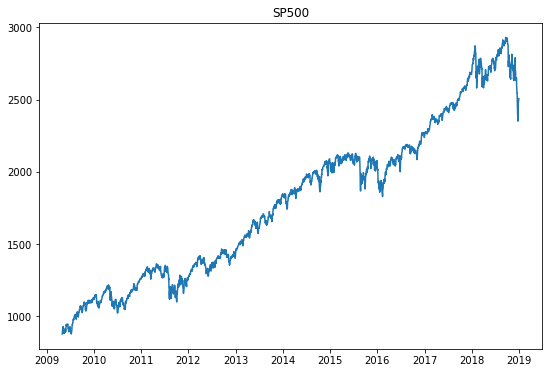

In [18]:
df = pd.read_csv('sample/sp500.csv')
df['Date'] = df['Date'].apply(pd.Timestamp)

# The paper only train on data from May 2009 to December 2018
df = df[(df['Date'] >= '2009-05-01') & (df['Date'] <= '2018-12-31')]
df = df.set_index('Date')
df = df['Adj Close']

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(df)
ax.set_title('SP500');

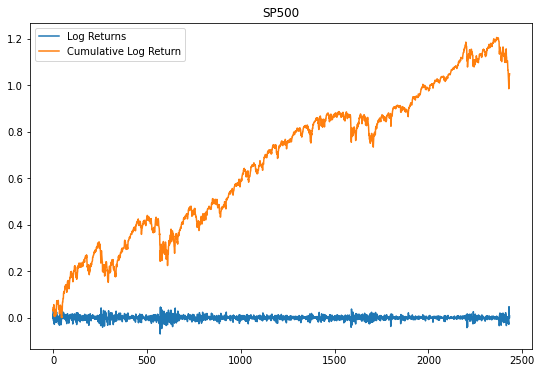

In [23]:
# Step 1: Log Return
log_returns = np.log(df/df.shift(1))[1:].to_numpy().reshape(-1, 1)

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(log_returns, label='Log Returns')
ax.plot(np.cumsum(log_returns), label='Cumulative Log Return')
ax.set_title('SP500')
plt.legend();

In [25]:
# Step 2-4
pipeline = Pipeline([
    ('scl1', StandardScaler()),
    ('gau', Gaussianize()),
    ('scl2', StandardScaler()),
])

log_returns_preprocessed = pipeline.fit_transform(log_returns)

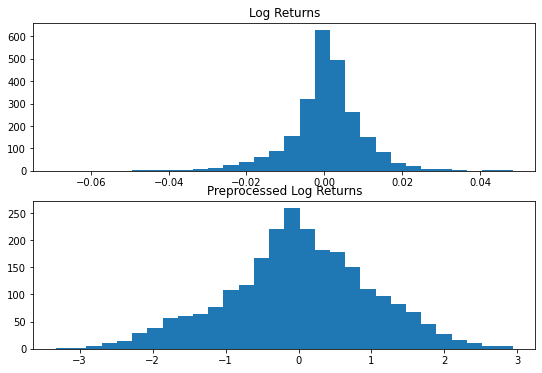

In [36]:
fig, axs = plt.subplots(2, 1, figsize=(9, 6))

axs[0].hist(log_returns, bins=30, label='Log Returns')
axs[0].set_title('Log Returns')
axs[1].hist(log_returns_preprocessed, bins=30, label='Preprocessed Log Returns')
axs[1].set_title('Preprocessed Log Returns');

In [37]:
# The step 5 (rolling window) is done when loading data
class StockDataset(Dataset):
    def __init__(self, data, length):
        assert len(data) >= length
        self.data = data
        self.length = length
    
    def __getitem__(self, idx):
        # Step 5: Rolling window
        return torch.tensor(self.data[idx:idx+self.length]).reshape(-1, self.length).to(torch.float32) # Rolling window
        
    def __len__(self):
        return max(len(self.data)-self.length, 0)

## GANs model

Before discussing the architecture of GANs, the Temporal Convolutional Network (TCN) block is explored here.


### Temporal Convolutional Networks

TCN consists of many *dilated causal convolutions*:
* Causal convolution is the convolution of which output only depends on the past sequence elements.
* Dilated convolutions are convolution with holes

TCN are parameterized by the kernel size $K$ and the dilation factor $D$.

Mathematically, the TCN could be defined as below:

> Let $N_I, N_H, N_O ∈ \Bbb{N}$ denote the input, hidden and output dimension and let $D,K ∈ \mathbb{N}$ denote the dilation and the kernel size. Furthermore, let $w_1, w_2$ be two dilated causal convolutional layers with arguments $(N_I, N_H, K, D)$  and $(N_H,N_O,K,D)$ respectively and
let $φ_1, φ_2 : \mathbb{R} → \mathbb{R}$ be two PReLUs. The function $f : \mathbb{R}^{N_I×(2D(K−1)+1)} → \mathbb{R}^{N_O}$ defined by
$$f(X) = φ_2 ◦ w_2 ◦ φ_1 ◦ w_1(X)$$
is called temporal block with arguments $(N_I,N_H,N_O,K,D)$.

The concept of residual connections also used in this paper so that connect every hidden layers with input as well as output of TCN.

![TCN architecture](images/tcn_with_skip_con.png)

*Figure. Architecture of TCN with skip-connections*

The usage of TCN could support the model capture long-range dependencies better than other RNN architectures. TCN also solved the problem of exponentially vanishing and exploding gradient through time.

### Generative adversarial networks

#### Model architecture

In Quant GANs, the GANs components (generator and discriminator) composed of many TCN layers as the below configurations:

| Module Name       | Arguments                    |
|-------------------|------------------------------|
| Temporal block 1  | ($N_I$, $N_H$, $N_H$, 1, 1)  |
| Temporal block 2  | ($N_I$, $N_H$, $N_H$, 2, 1)  |
| Temporal block 3  | ($N_I$, $N_H$, $N_H$, 2, 2)  |
| Temporal block 4  | ($N_I$, $N_H$, $N_H$, 2, 4)  |
| Temporal block 5  | ($N_I$, $N_H$, $N_H$, 2, 8)  |
| Temporal block 6  | ($N_I$, $N_H$, $N_H$, 2, 16) |
| Temporal block 7  | ($N_I$, $N_H$, $N_H$, 2, 32) |
| 1 x 1 Convolution | ($N_H$, $N_O$, 1, 1)         |

However, the parameters are different in generator and discriminator:

| Models    | Generator | Discriminator |
|-----------|-----------|---------------|
| $N_I$     | 3         | 1             |
| $N_H$     | 80        | 80            |
| $N_O$     | 1         | 1             |

The below code is the implementation of GAN model. Mostly the code was adapted from repository [JamesSullivan/temporalCN](https://github.com/JamesSullivan/temporalCN) but I changed the norm layer from `weight_norm` to `spectral_norm` according to [ICascha/QuantGANs-replication](https://github.com/ICascha/QuantGANs-replication)

In [43]:
import torch.nn as nn
from torch.nn.utils import weight_norm, spectral_norm

class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    """Creates a temporal block.
    Args:
        n_inputs (int): number of inputs.
        n_outputs (int): size of fully connected layers.
        kernel_size (int): kernel size along temporal axis of convolution layers within the temporal block.
        dilation (int): dilation of convolution layers along temporal axis within the temporal block.
        padding (int): padding
        dropout (float): dropout rate
    Returns:
        tuple of output layers
    """
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = spectral_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size, stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.PReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = spectral_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size, stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.PReLU()
        self.dropout2 = nn.Dropout(dropout)

        if padding == 0:
            self.net = nn.Sequential(self.conv1, self.relu1, self.dropout1, self.conv2, self.relu2, self.dropout2)
        else:
            self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1, self.conv2, self.chomp2, self.relu2, self.dropout2)

        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.PReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.5)
        self.conv2.weight.data.normal_(0, 0.5)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.5)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return out, self.relu(out + res)



class Generator(nn.Module):
    """Generator: 3 to 1 Causal temporal convolutional network with skip connections.
       This network uses 1D convolutions in order to model multiple timeseries co-dependency.
    """ 
    def __init__(self):
        super(Generator, self).__init__()
        self.tcn = nn.ModuleList([TemporalBlock(3, 80, kernel_size=1, stride=1, dilation=1, padding=0),
                                 *[TemporalBlock(80, 80, kernel_size=2, stride=1, dilation=i, padding=i) for i in [1, 2, 4, 8, 16, 32]]])
        self.last = nn.Conv1d(80, 127, kernel_size=1, stride=1, dilation=1)

    def forward(self, x):
        skip_layers = []
        for layer in self.tcn:
            skip, x = layer(x)
            skip_layers.append(skip)
        x = self.last(x + sum(skip_layers))
        return x.permute(0, 2, 1)


class Discriminator(nn.Module):
    """Discrimnator: 1 to 1 Causal temporal convolutional network with skip connections.
       This network uses 1D convolutions in order to model multiple timeseries co-dependency.
    """ 
    def __init__(self, seq_len, conv_dropout=0.05):
        super(Discriminator, self).__init__()
        self.tcn = nn.ModuleList([TemporalBlock(1, 80, kernel_size=1, stride=1, dilation=1, padding=0),
                                 *[TemporalBlock(80, 80, kernel_size=2, stride=1, dilation=i, padding=i) for i in [1, 2, 4, 8, 16, 32]]])
        self.last = nn.Conv1d(80, 1, kernel_size=1, dilation=1)
        self.to_prob = nn.Sequential(nn.Linear(seq_len, 1), nn.Sigmoid())

    def forward(self, x):
        skip_layers = []
        for layer in self.tcn:
            skip, x = layer(x)
            skip_layers.append(skip)
        
        x = x + sum(skip_layers)
        x = self.last(x)
        
        return self.to_prob(x).squeeze()

#### Loss function

Let denote:

> Generator is a network with parameter space $\Omega^{(g)}$:
> $$g: \mathbb{R}^{N_Z} \times \Omega^{(g)} \rightarrow \mathbb{R}^{N_Z}$$
> Discriminator $d$ is the composition of network $\tilde{d}$ and sigmoid function $\sigma$:
> $$\tilde{d}: \mathbb{R}^{N_Z} \times \Omega^{(d)} \rightarrow \mathbb{R}$$
> $$\sigma: \mathbb{R} \rightarrow [0,1]: x \rightarrow \frac{1}{1 + \exp{-x}}$$
> $$d: (n, \eta) \rightarrow \sigma \circ \tilde{d}_\eta (x)$$

By the above definition, the loss function is defined by:

$$ L(\theta, \eta) := \mathbb{E} \left [ \log (d_\eta (X) \right ] + \mathbb{E} \left [ \log (1- d_\eta (g_\theta (Z)) \right ]$$

with $Z$ is the noise prior and $X$ is the targeted (or data) random variable.

The objective of training step is a min-max game that optimize:

$$ \min_{\theta \in \Omega^{(g)}} \max_{\eta \in \Omega^{(d)}} L (\theta, \eta) $$

#### Training step

The generator’s and discriminator’s parameters $(\theta, \eta)$ are trained by alternating the
computation of their gradients $\nabla_\eta L(\theta, \eta)$ and $\nabla_\theta L(\theta, \eta)$ and updating their respective parameters. To get a close approximation of the optimal discriminator $d_{\eta *}$ (Goodfellow et al., 2014, Proposition 1) it is common to compute the discriminators gradient multiple times and ascent the parameters $\eta$.

The detailed training code was showed below:

In [65]:
seq_len = 127
batch_size = 80
num_epochs = 100
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 0.0001
clip = 0.01
nz = 3
train_gen_per_epoch=5

# Setup the dataloader
dataset = StockDataset(log_returns_preprocessed, seq_len)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
progressing_bar = tqdm(range(num_epochs))

history = dict(gen_loss=[], disc_loss=[])

# Initialize the generator and discriminator
generator = Generator().to(device)
discriminator = Discriminator(seq_len).to(device)

# Setup the optimizer
disc_optimizer = optim.RMSprop(discriminator.parameters(), lr=lr)
gen_optimizer = optim.RMSprop(generator.parameters(), lr=lr)

# Training loop
for epoch in progressing_bar:
    progressing_bar.set_description('Epoch %d' % (epoch))

    for idx, data in enumerate(dataloader, 0):

        # Train the discriminator
        discriminator.zero_grad()
        real = data.to(device)
        batch_size, seq_len = real.size(0), real.size(1)
        noise = torch.randn(batch_size, nz, seq_len, device=device)
        fake = generator(noise).detach()

        disc_loss = -torch.mean(discriminator(real)) + torch.mean(discriminator(fake))
        disc_loss.backward()
        disc_optimizer.step()

        for dp in discriminator.parameters():
            dp.data.clamp_(-clip, clip)

        # Train the generator
        if idx % train_gen_per_epoch == 0:
            generator.zero_grad()
            gen_loss = -torch.mean(discriminator(generator(noise)))
            gen_loss.backward()
            gen_optimizer.step()   

        history['gen_loss'].append(gen_loss.item())
        history['disc_loss'].append(disc_loss.item())
    progressing_bar.set_postfix_str('DiscLoss: %.4e, GenLoss: %.4e' % (disc_loss.item(), gen_loss.item()))

  0%|          | 0/100 [00:00<?, ?it/s]

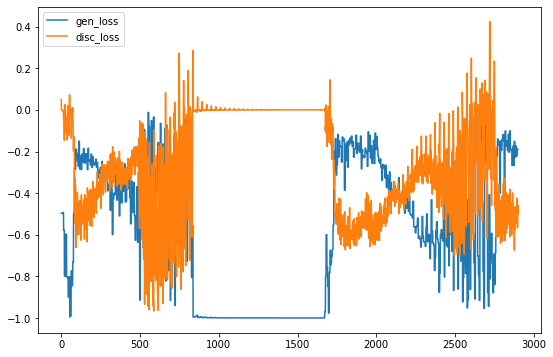

In [66]:
# Visualize the loss
fig, ax = plt.subplots(figsize=(9, 6))
# ax2 = ax.twinx()

p1 = ax.plot(history['gen_loss'], label='gen_loss', color='tab:blue')
p2 = ax.plot(history['disc_loss'], label='disc_loss', color='tab:orange')
ax.legend(handles=p1+p2);

In [68]:
# Inferennce
generator.eval()
noise = torch.randn(batch_size, nz, seq_len).to(device)
with torch.no_grad():
    y = generator(noise).cpu().detach().squeeze()

In [69]:
standardScaler1, gaussianize, standardScaler2 = pipeline[0], pipeline[1], pipeline[2]
y = (y - y.mean(axis=0))/y.std(axis=0)
y = standardScaler2.inverse_transform(y)
y = np.array([gaussianize.inverse_transform(np.expand_dims(x, 1)) for x in y]).squeeze()
y = standardScaler1.inverse_transform(y)

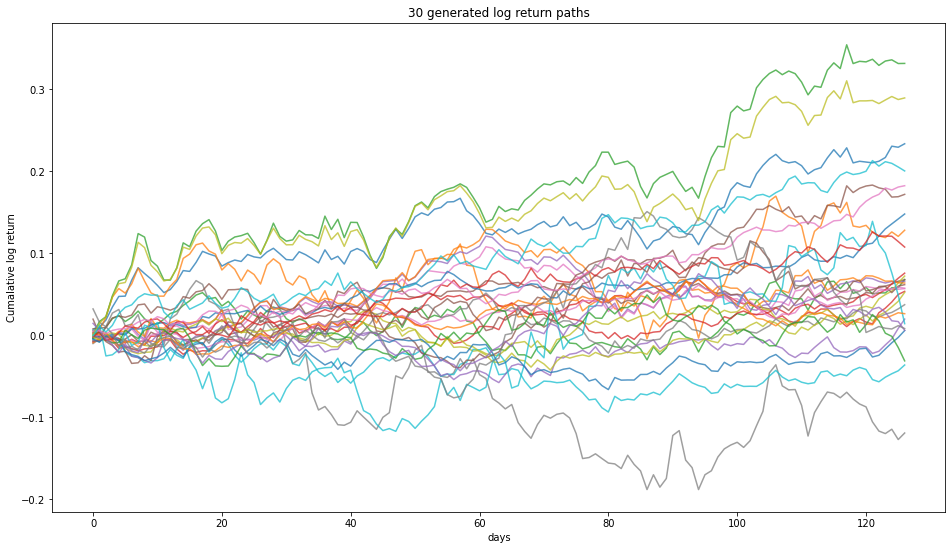

In [70]:
# Chart 1
_, ax = plt.subplots(figsize=(16,9))
ax.plot(np.cumsum(y[0:30], axis=1).T, alpha=0.75)
ax.set_title('30 generated log return paths'.format(len(y)))
ax.set_xlabel('days')
ax.set_ylabel('Cumalative log return');

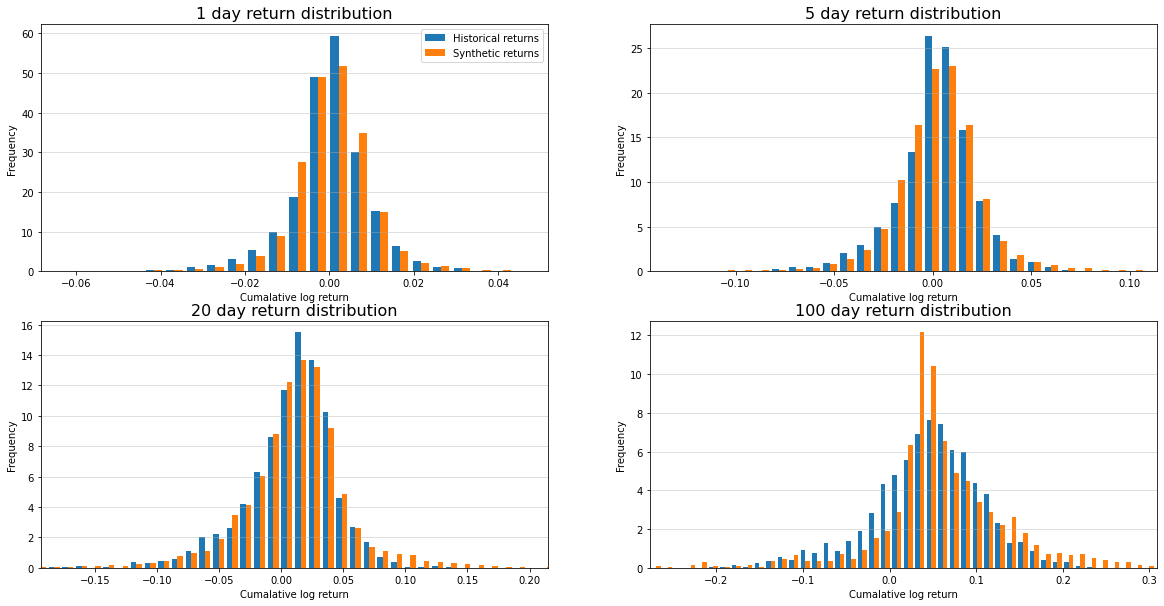

In [73]:
# Chart 2
n_bins = 50
windows = [1, 5, 20, 100]
_, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
for i in range(len(windows)):
    row = min(max(0, i-1), 1)
    col = i % 2
    real_dist = rolling_window(log_returns, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    fake_dist = rolling_window(y.T, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    axs[row, col].hist(np.array([real_dist, fake_dist], dtype='object'), bins=n_bins, density=True)
    axs[row,col].set_xlim(*np.quantile(fake_dist, [0.001, .999]))

    axs[row,col].set_title('{} day return distribution'.format(windows[i]), size=16)
    axs[row,col].yaxis.grid(True, alpha=0.5)
    axs[row,col].set_xlabel('Cumalative log return')
    axs[row,col].set_ylabel('Frequency')
axs[0,0].legend(['Historical returns', 'Synthetic returns'])

**Comment:** the distribution of generated data and real data are similar.

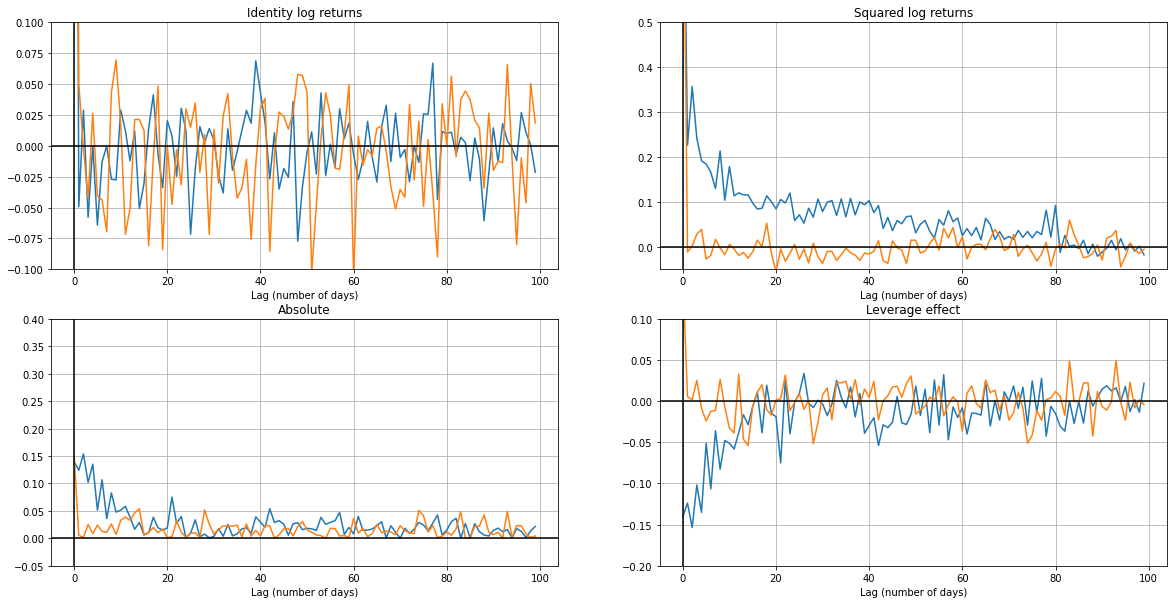

In [77]:
#Chart 3
_, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

axs[0,0].plot(acf(log_returns, 100))
axs[0,0].plot(acf(y.T, 100).mean(axis=1))
axs[0,0].set_ylim(-0.1, 0.1)
axs[0,0].set_title('Identity log returns')
axs[0,1].plot(acf(log_returns**2, 100))
axs[0,1].set_ylim(-0.05, 0.5)
axs[0,1].plot(acf(y.T**2, 100).mean(axis=1))
axs[0,1].set_title('Squared log returns')
axs[1,0].plot(abs(acf(log_returns, 100, le=True)))
axs[1,0].plot(abs(acf(y.T, 100, le=True).mean(axis=1)))
axs[1,0].set_ylim(-0.05, 0.4)
axs[1,0].set_title('Absolute')
axs[1,1].plot(acf(log_returns, 100, le=True))
axs[1,1].plot(acf(y.T, 100, le=True).mean(axis=1))
axs[1,1].set_ylim(-0.2, 0.1)
axs[1,1].set_title('Leverage effect')


for ax in axs.flat: 
    ax.grid(True)
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
plt.setp(axs, xlabel='Lag (number of days)');

**Comment:** ACF value of generated data and real data are almost the same